<a href="https://colab.research.google.com/github/paulinavaso/Tesis/blob/main/GPFlow_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install gpflow
#!pip install tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

In [ ]:
N = 100  # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [ ]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]

    return X, Y

In [ ]:
X, Y = data = generate_data(N)
Zinit = np.linspace(-5, 5, M)[:, None]

In [ ]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {m.elbo(data):.3}")
    plt.plot(Z, Z * 0.0, "o")

In [ ]:
# create multi-output kernel
kernel = gpf.kernels.SharedIndependent(
    gpf.kernels.SquaredExponential() + gpf.kernels.Linear(), output_dim=P
)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [ ]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-5....
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1., 0., 0...."


In [ ]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": MAXITER},
    )


optimize_model_with_scipy(m)

In [ ]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.8359580418378612
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.7890030187917806
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.2024025910268545
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.03804151796426614
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-4.78398344...
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[-0.8971457, 0.70365458, -1.51000568..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1.69255586e-02, 0.00000000e+00, 0.00000000e+00..."


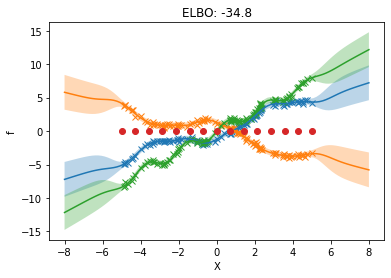

In [ ]:
# Plot predictions and observations
plot_model(m)

In [ ]:
print_summary(m.kernel)
m.kernel.kernel.kernels[0].lengthscales

name,class,transform,prior,trainable,shape,dtype,value
SharedIndependent.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.835958
SharedIndependent.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.789003
SharedIndependent.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.2024


<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.7890030187917806>